In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.stats import describe
import math
import os
import glob
import datetime
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
sns.set_theme(style="darkgrid")
### Separate file with functions
execfile("functions/_plot_and_wrangling_functions.py")
import warnings
warnings.filterwarnings('ignore')

In [31]:
glob.glob('../data/*')

['../data\\holidays_events.csv',
 '../data\\oil.csv',
 '../data\\sample_submission.csv',
 '../data\\stores.csv',
 '../data\\test.csv',
 '../data\\train.csv',
 '../data\\transactions.csv']

In [32]:
train_df = pd.read_csv('../data/train.csv')
holidays_df = pd.read_csv('../data/holidays_events.csv')
oil_df = pd.read_csv('../data/oil.csv')
stores_df = pd.read_csv('../data/stores.csv')
transactions_df = pd.read_csv('../data/transactions.csv')
sample_df = pd.read_csv('../data/sample_submission.csv')
test_df = pd.read_csv('../data/test.csv')

##### Understanding Holidays

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [33]:
holidays_df.head(1)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False


In [34]:
holidays_df.query('type == "Transfer"').head(1)

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False


In [35]:
### We drop every row where the tranferred == True, since the database already provides a new row to when the holiday was transferred to
### A better approach would test if the transferred holidays have any significant impact compared to regular holidays or create
### a column for each holiday with a boolean value if it is that holiday or not
holidays_df2 = holidays_df[holidays_df['transferred'] == False].copy()

In [36]:
holidays_df2.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [37]:
#### Now we group the dataframe to have only the date, locale and locale_name, which will be our keys for future joins
#### Using this approach, we will create a single column in the training dataframe if is holiday or not
#### Another option would be creating a boolean value per holiday so we can also measure different impacts on the sales
holidays_df3 = (holidays_df2.groupby(['date','locale','locale_name'], as_index = False)['description'].count()
                .sort_values(by = ['description'], ascending= [False]))

In [38]:
holidays_df4 = holidays_df3[['date','locale','locale_name']].drop_duplicates() 

In [39]:
holidays_df4.sort_values(by = 'date')

,date,locale,locale_name
0,2012-03-02,Local,Manta
1,2012-04-01,Regional,Cotopaxi
2,2012-04-12,Local,Cuenca
3,2012-04-14,Local,Libertad
4,2012-04-21,Local,Riobamba
...,...,...,...
326,2017-12-22,National,Ecuador
327,2017-12-23,National,Ecuador
328,2017-12-24,National,Ecuador
329,2017-12-25,National,Ecuador


#### Working with oil dataset

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

Since this is a stock information, we need to fill in the days that there is no market trade

In [40]:
print(f'There are {train_df["date"].nunique() + test_df["date"].nunique()} days available in the dataset')
print(f'But there are {(pd.to_datetime(test_df["date"].max()) - pd.to_datetime(train_df["date"].min()))} days between first and last day')

There are 1700 days available in the dataset
But there are 1703 days 00:00:00 days between first and last day


In [41]:
#### We create a dataframe with the first day available in the train_df and with the last day of test_df and set the freq to daily
totaldays = pd.DataFrame({'date': pd.date_range(start = train_df['date'].min(), end = test_df['date'].max())})
totaldays['date'].freq = 'd'

In [42]:
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [43]:
#### Merge the two dataframes and do a backward fill to get the correct values of the day
#### then we transform the column to datetime format. Now we can plot and understand the data
oil_df2 = totaldays.merge(oil_df, how = 'left', on = 'date').bfill()
oil_df2['date'] = pd.to_datetime(oil_df2['date'])

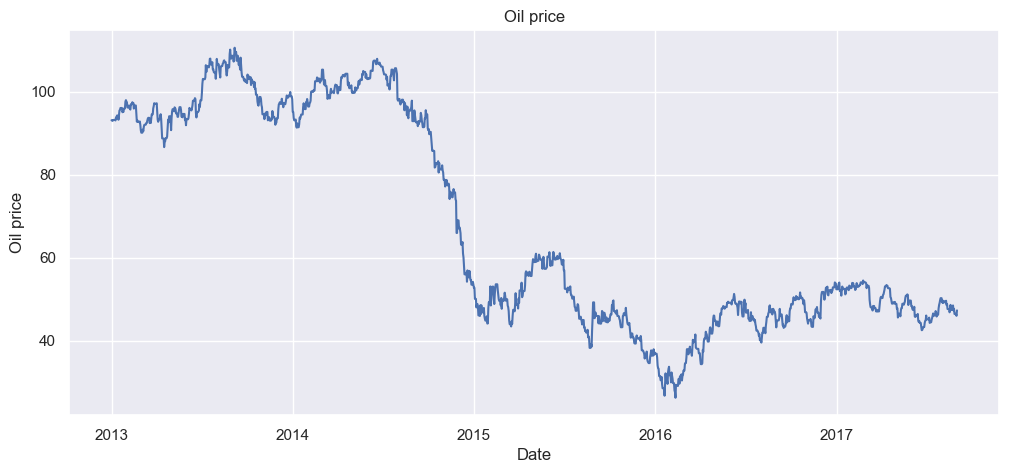

In [44]:
#### We can see there is a oil shock between 2014 and 2015. After that it slowly decreased until it hits the bottom in 2016.
### After that it stayed stable up until the last day of the dataset.
plt.figure(figsize = (12,5))
sns.lineplot(oil_df2, x = 'date', y = 'dcoilwtico')
plt.title('Oil price')
plt.xlabel('Date')
plt.ylabel('Oil price')
plt.show()

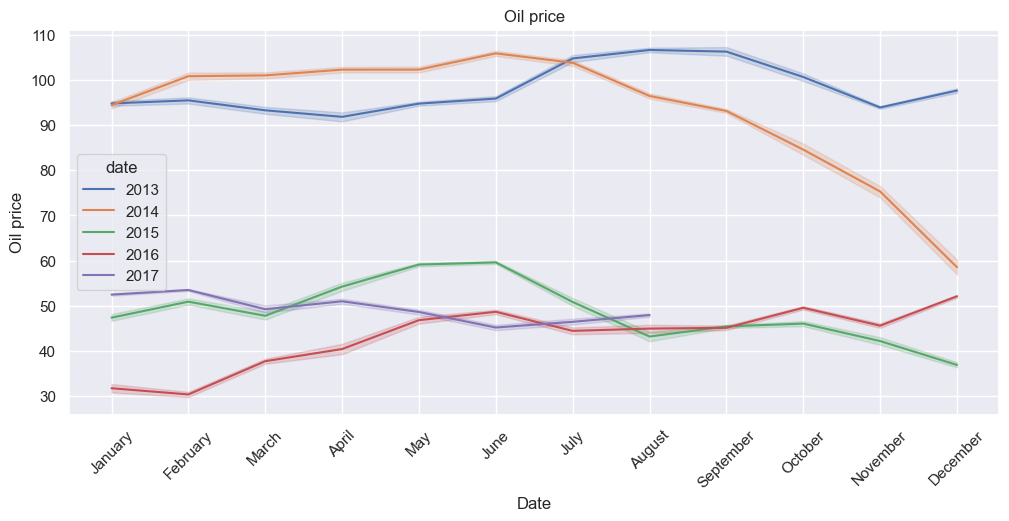

In [45]:
#### We can also check for seasonality between the years. We can't clearly see any monthly pattern, so we use can use a seasonal decompose
#### to evaluate the other seasonalities
plt.figure(figsize = (12,5))
(sns.lineplot(oil_df2, 
              x = oil_df2['date'].dt.strftime('%B'), 
              y = 'dcoilwtico', 
              hue = oil_df2['date'].dt.strftime('%Y'),
              ))
plt.title('Oil price')
plt.xlabel('Date')
plt.ylabel('Oil price')
plt.xticks(rotation = 45)
plt.show()

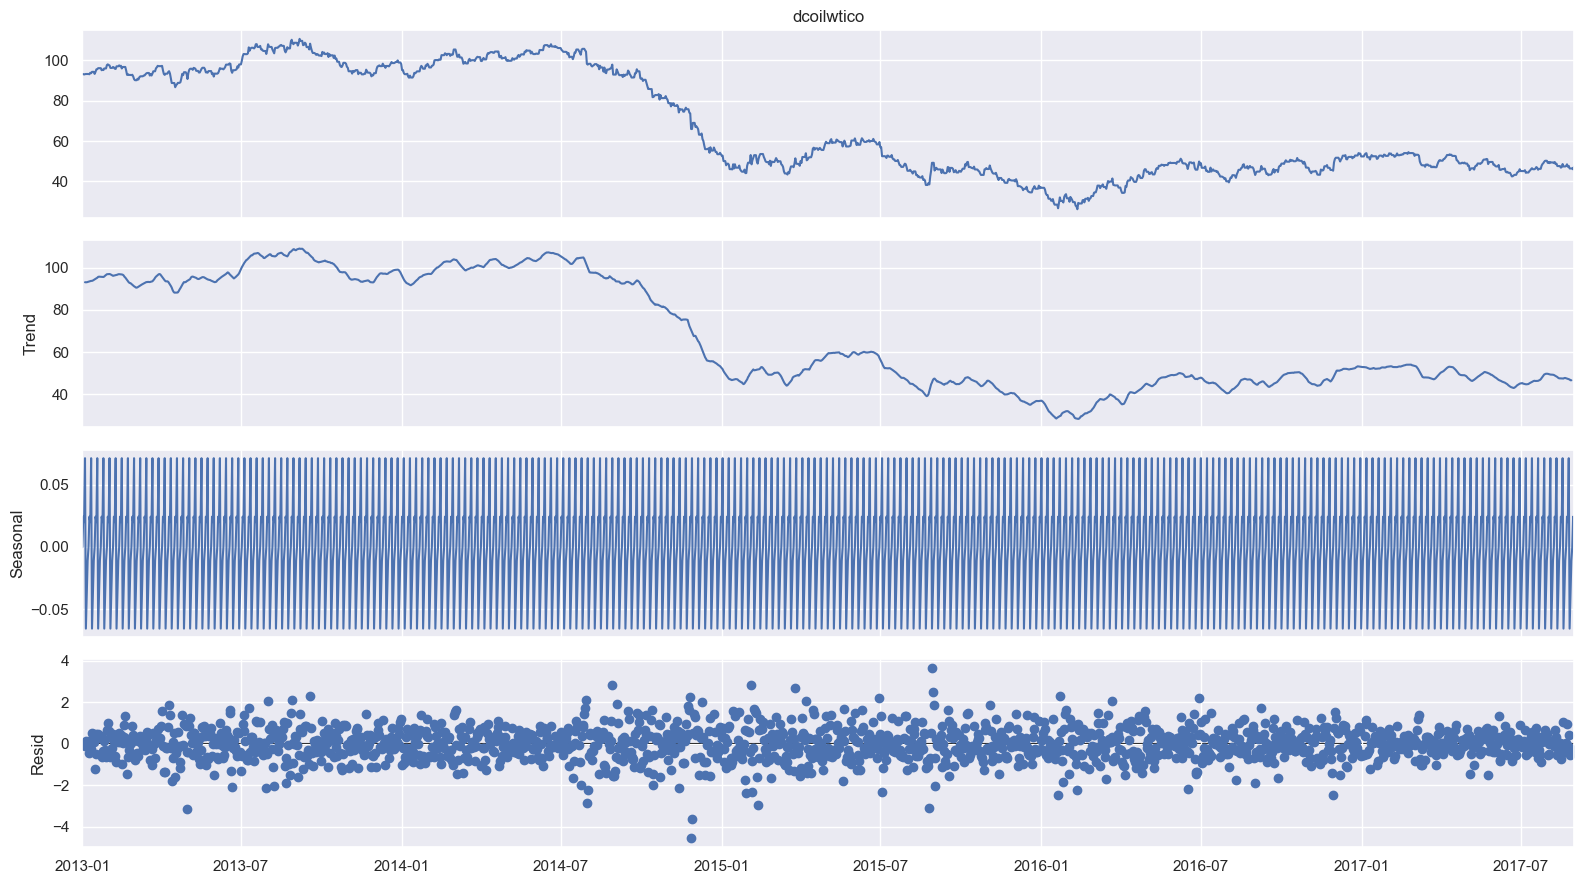

In [46]:
#Test for Seasonality
# Perform seasonal decomposition
oil_df3 = oil_df2.copy()#[oil_df2['date'].between('2013-01-01','2014-01-01')].copy()
oil_df3.set_index('date', inplace = True)
oil_df3.index.freq = 'd'
res = sm.tsa.seasonal_decompose(oil_df3.dcoilwtico)

# Create a larger figure and plot the decomposed components
fig = res.plot()
fig.set_size_inches((16,9))
fig.tight_layout()
plt.show()

#### Evaluating total sales

In [47]:
sales_df = train_df.copy()
sales_df['date'] = pd.to_datetime(sales_df['date'])

In [48]:
total_sales = sales_df.groupby(['date'], as_index = False)[['sales','onpromotion']].sum()

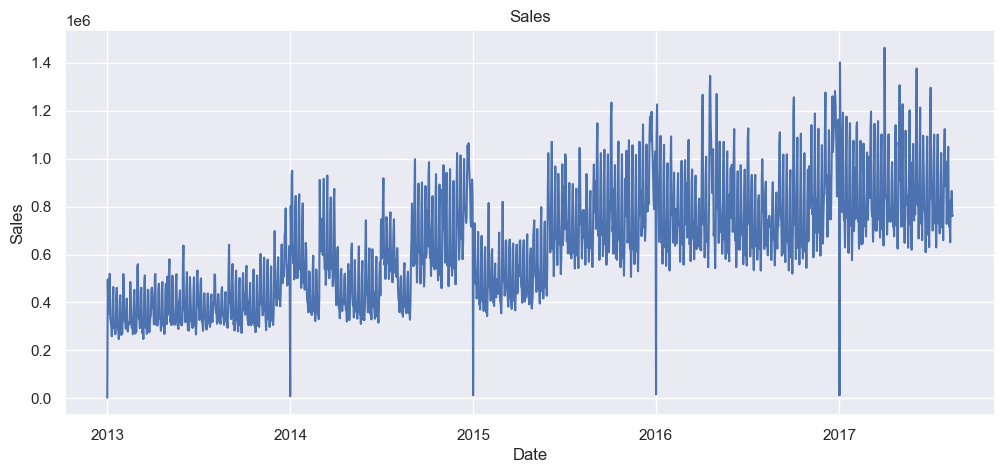

In [49]:
#### We can see there is a oil shock between 2014 and 2015. After that it slowly decreased until it hits the bottom in 2016.
### After that it stayed stable up until the last day of the dataset.
plt.figure(figsize = (12,5))
sns.lineplot(total_sales, x = 'date', y = 'sales')
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

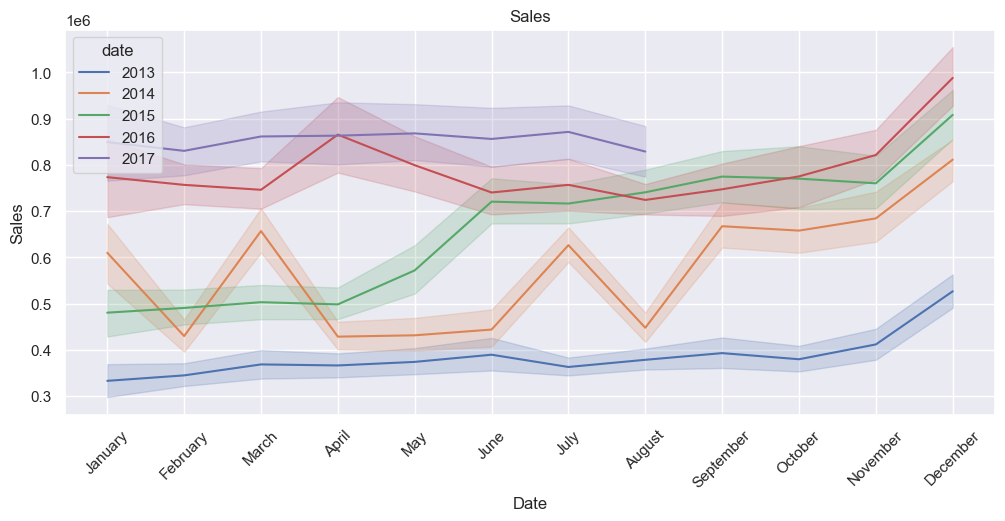

In [50]:
#### We can also check for seasonality between the years. We can't clearly see any monthly pattern, so we use can use a seasonal decompose
#### to evaluate the other seasonalities
plt.figure(figsize = (12,5))
(sns.lineplot(total_sales, 
              x = total_sales['date'].dt.strftime('%B'), 
              y = 'sales', 
              hue = total_sales['date'].dt.strftime('%Y'),
              ))
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

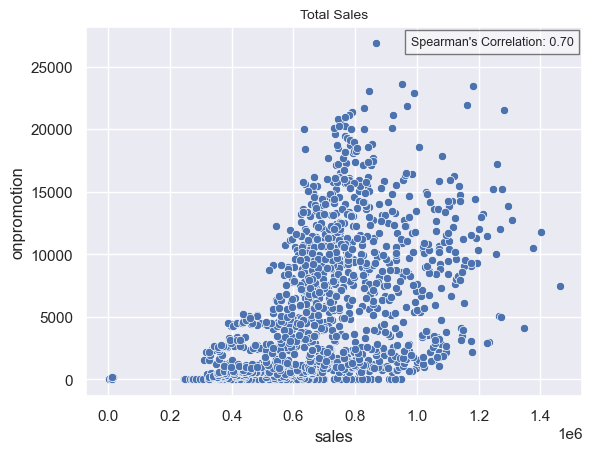

In [51]:
sns.scatterplot(data=total_sales, x='sales', y='onpromotion')

# Spearman correlation
spearman_correlation = total_sales['sales'].corr(total_sales['onpromotion'], method='spearman')
textstr = f"Spearman's Correlation: {spearman_correlation:.2f}"

# Add correlation text

plt.text(
    x=total_sales['sales'].max() * 0.67,
    y=total_sales['onpromotion'].max() * 0.995,
    s=textstr,
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
)
plt.title(f"Total Sales", fontsize=10)
plt.show()

In [52]:
### Evaluating stationarity in the series -> It is a non-stationary series. We can differentiate and check again
check_stationarity(total_sales['sales'])

ADF Statistic: -2.616196
p-value: 0.089696
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Non-stationary


In [53]:
total_sales['dif_sales'] = total_sales['sales'].diff()
total_sales['dif_sales'].fillna(0, inplace = True)

In [54]:
### For models that require a stationary series, we can use the differentiation of the series
check_stationarity(total_sales['dif_sales'])

ADF Statistic: -11.495798
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary


#### Evaluating Sales per product

In [55]:
prd_sales_df = sales_df.groupby(['date','family'], as_index=False)[['sales','onpromotion']].sum()

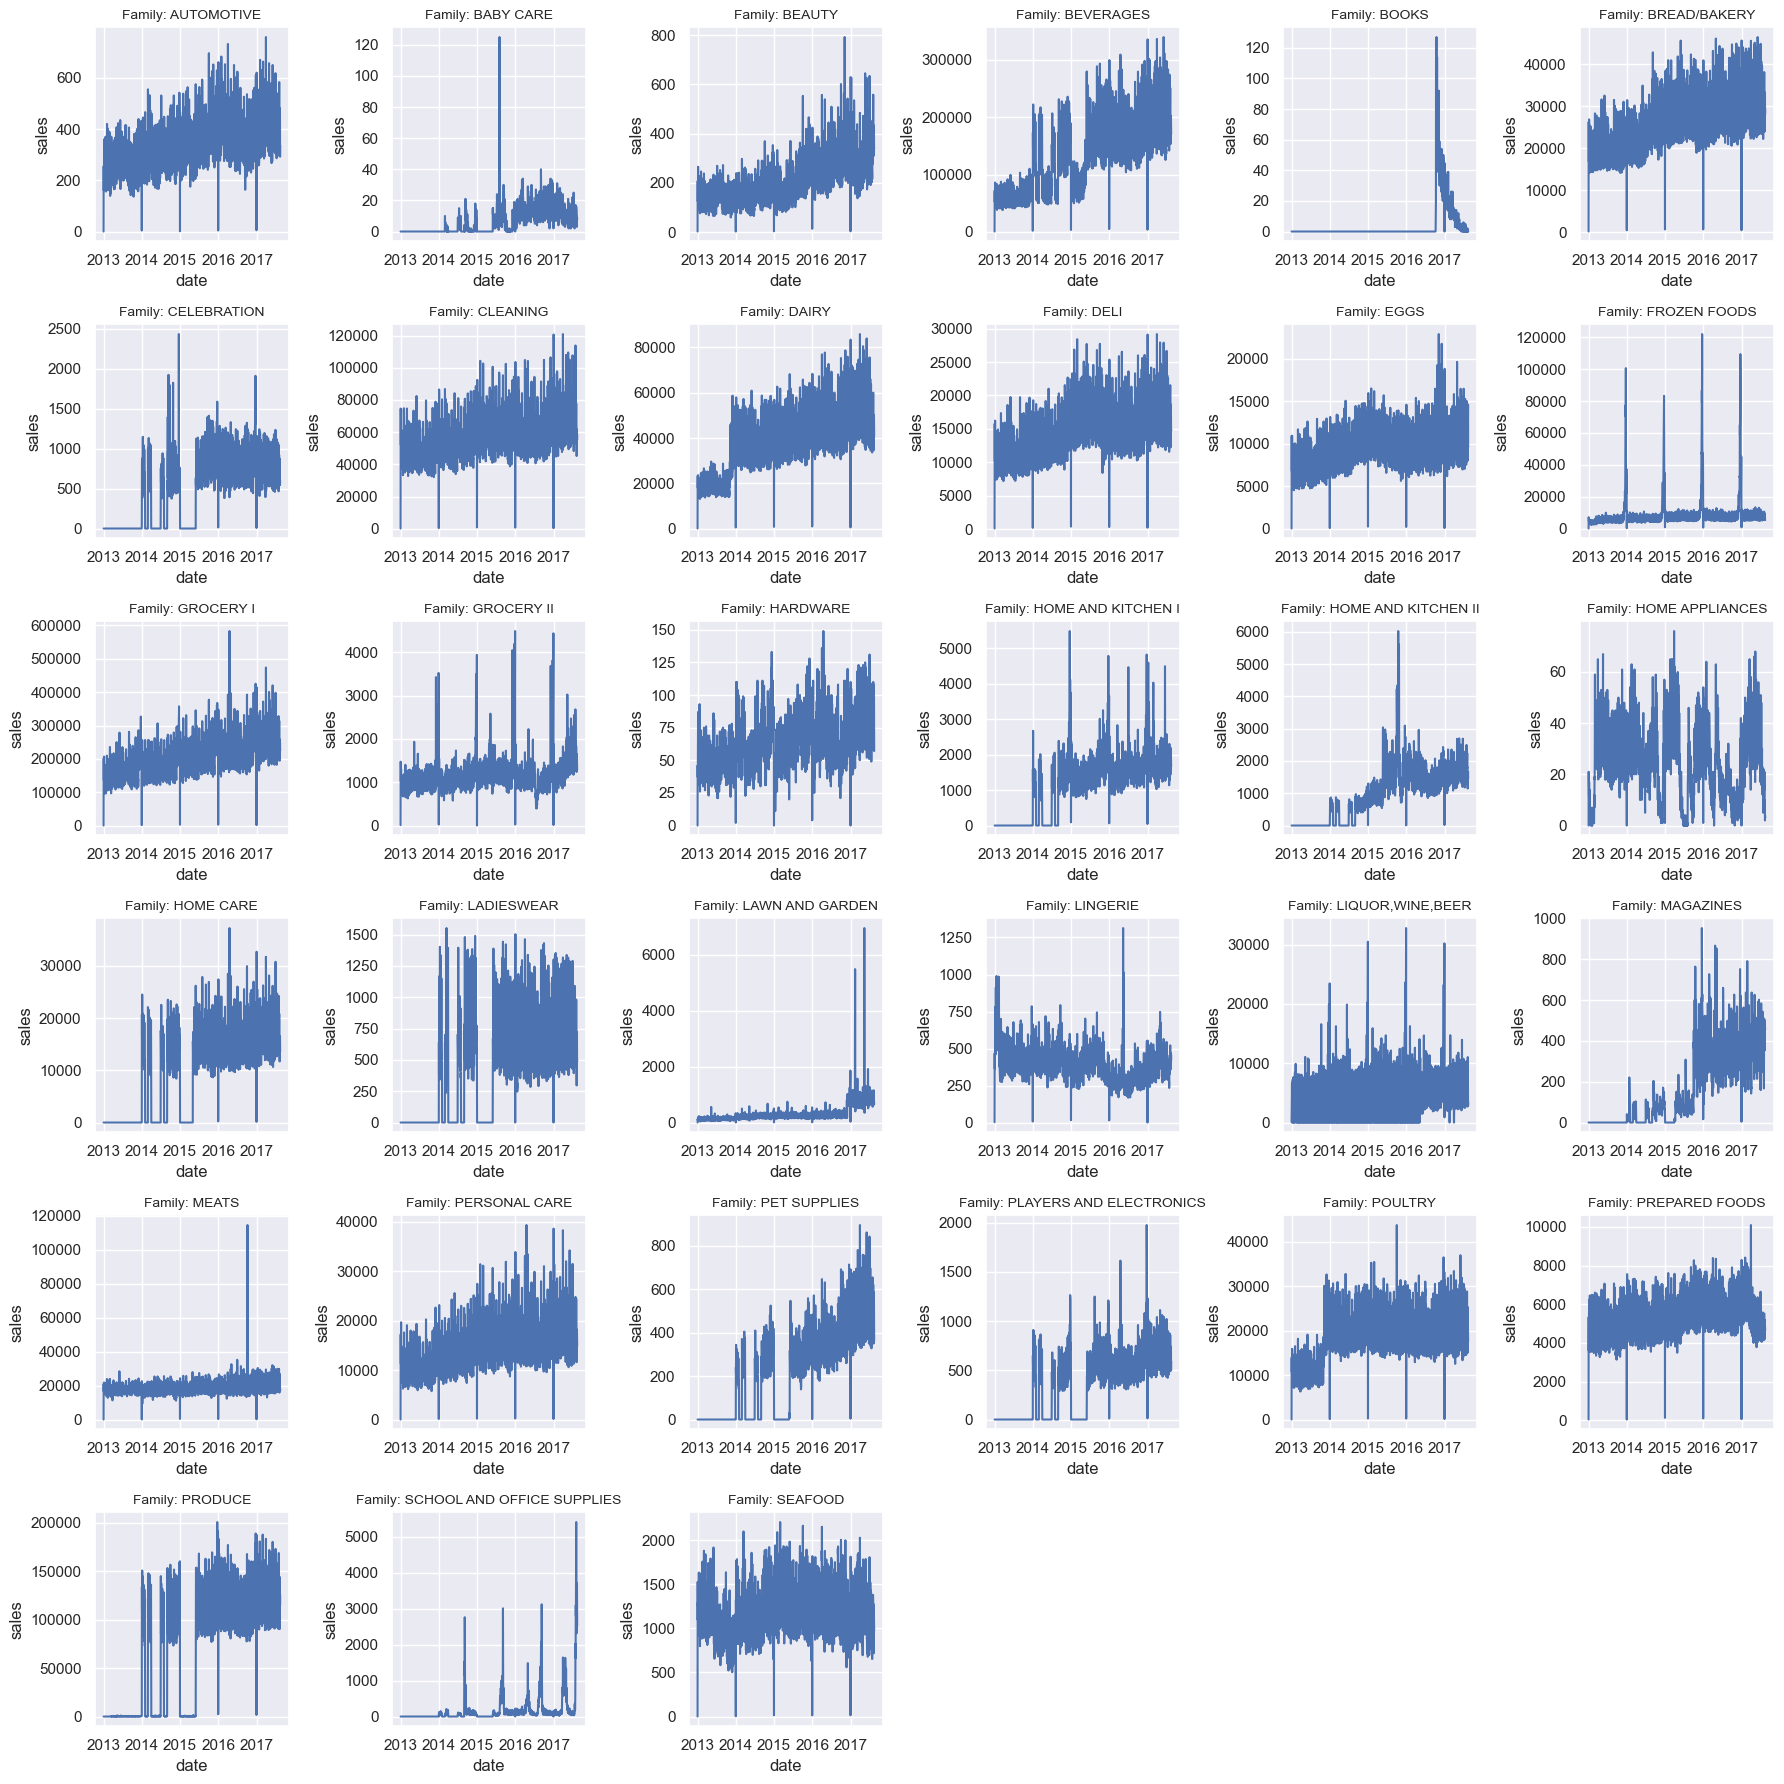

In [56]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Scatter plot
    sns.lineplot(ax=axes[j], data=temp_filter, x='date', y='sales')
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

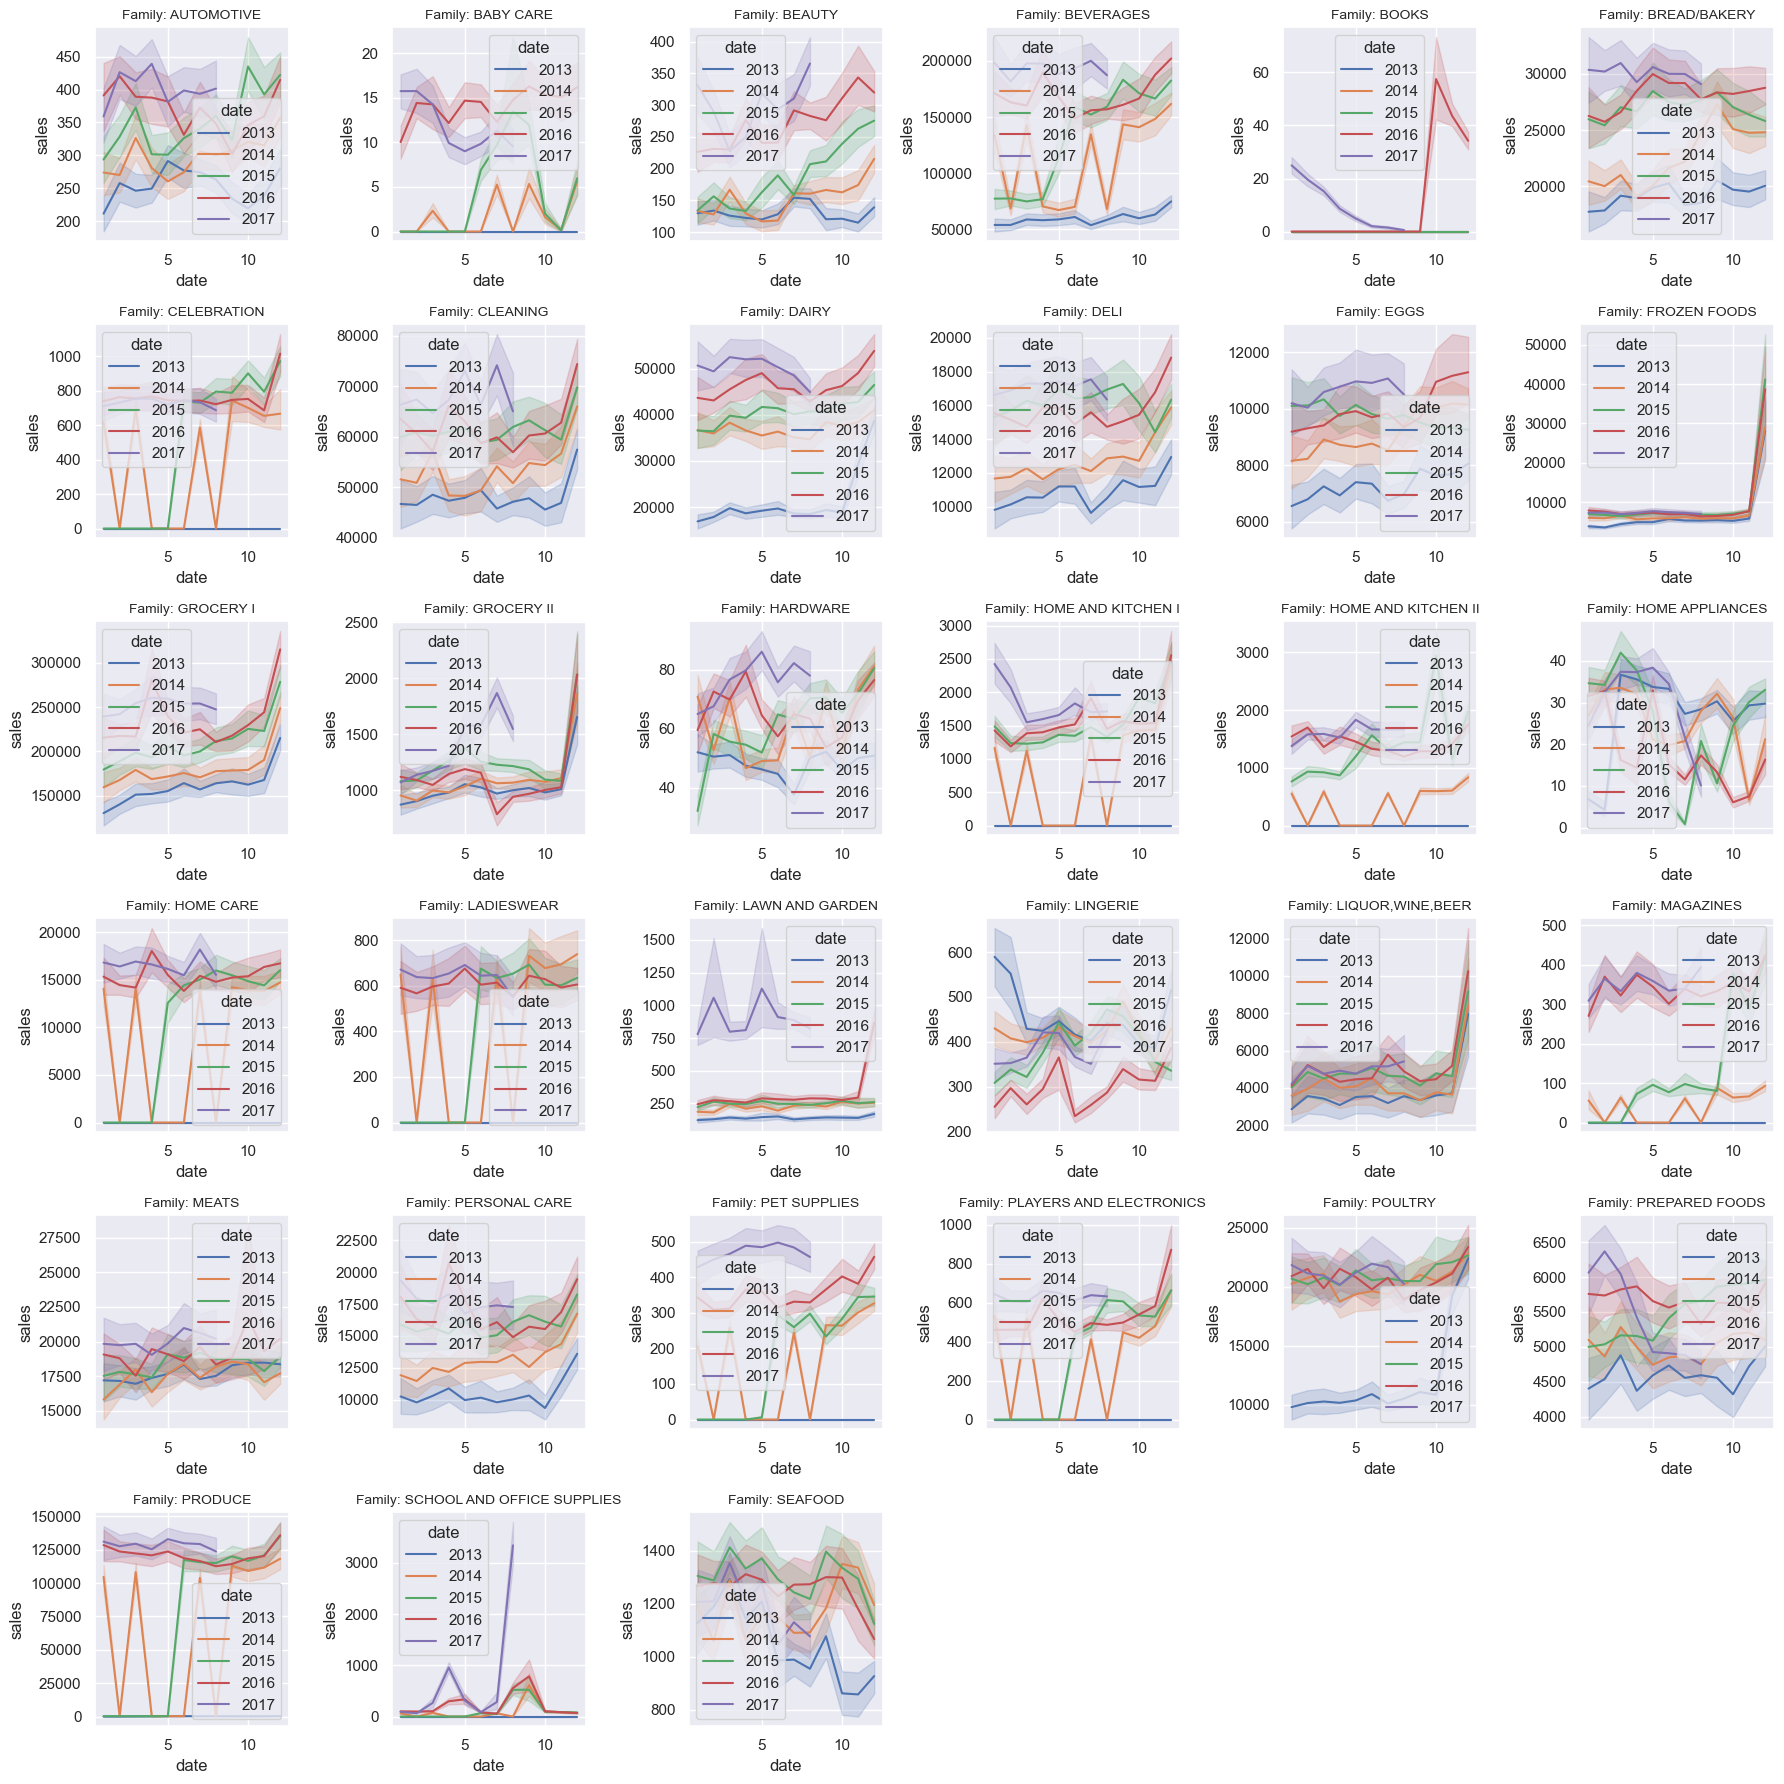

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Creation of the subplot based on the amount of product families available
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Line plot
    (sns.lineplot(ax=axes[j], data = temp_filter, 
              x = temp_filter['date'].dt.month, 
              y = 'sales', 
              hue = temp_filter['date'].dt.strftime('%Y'),
              ))
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

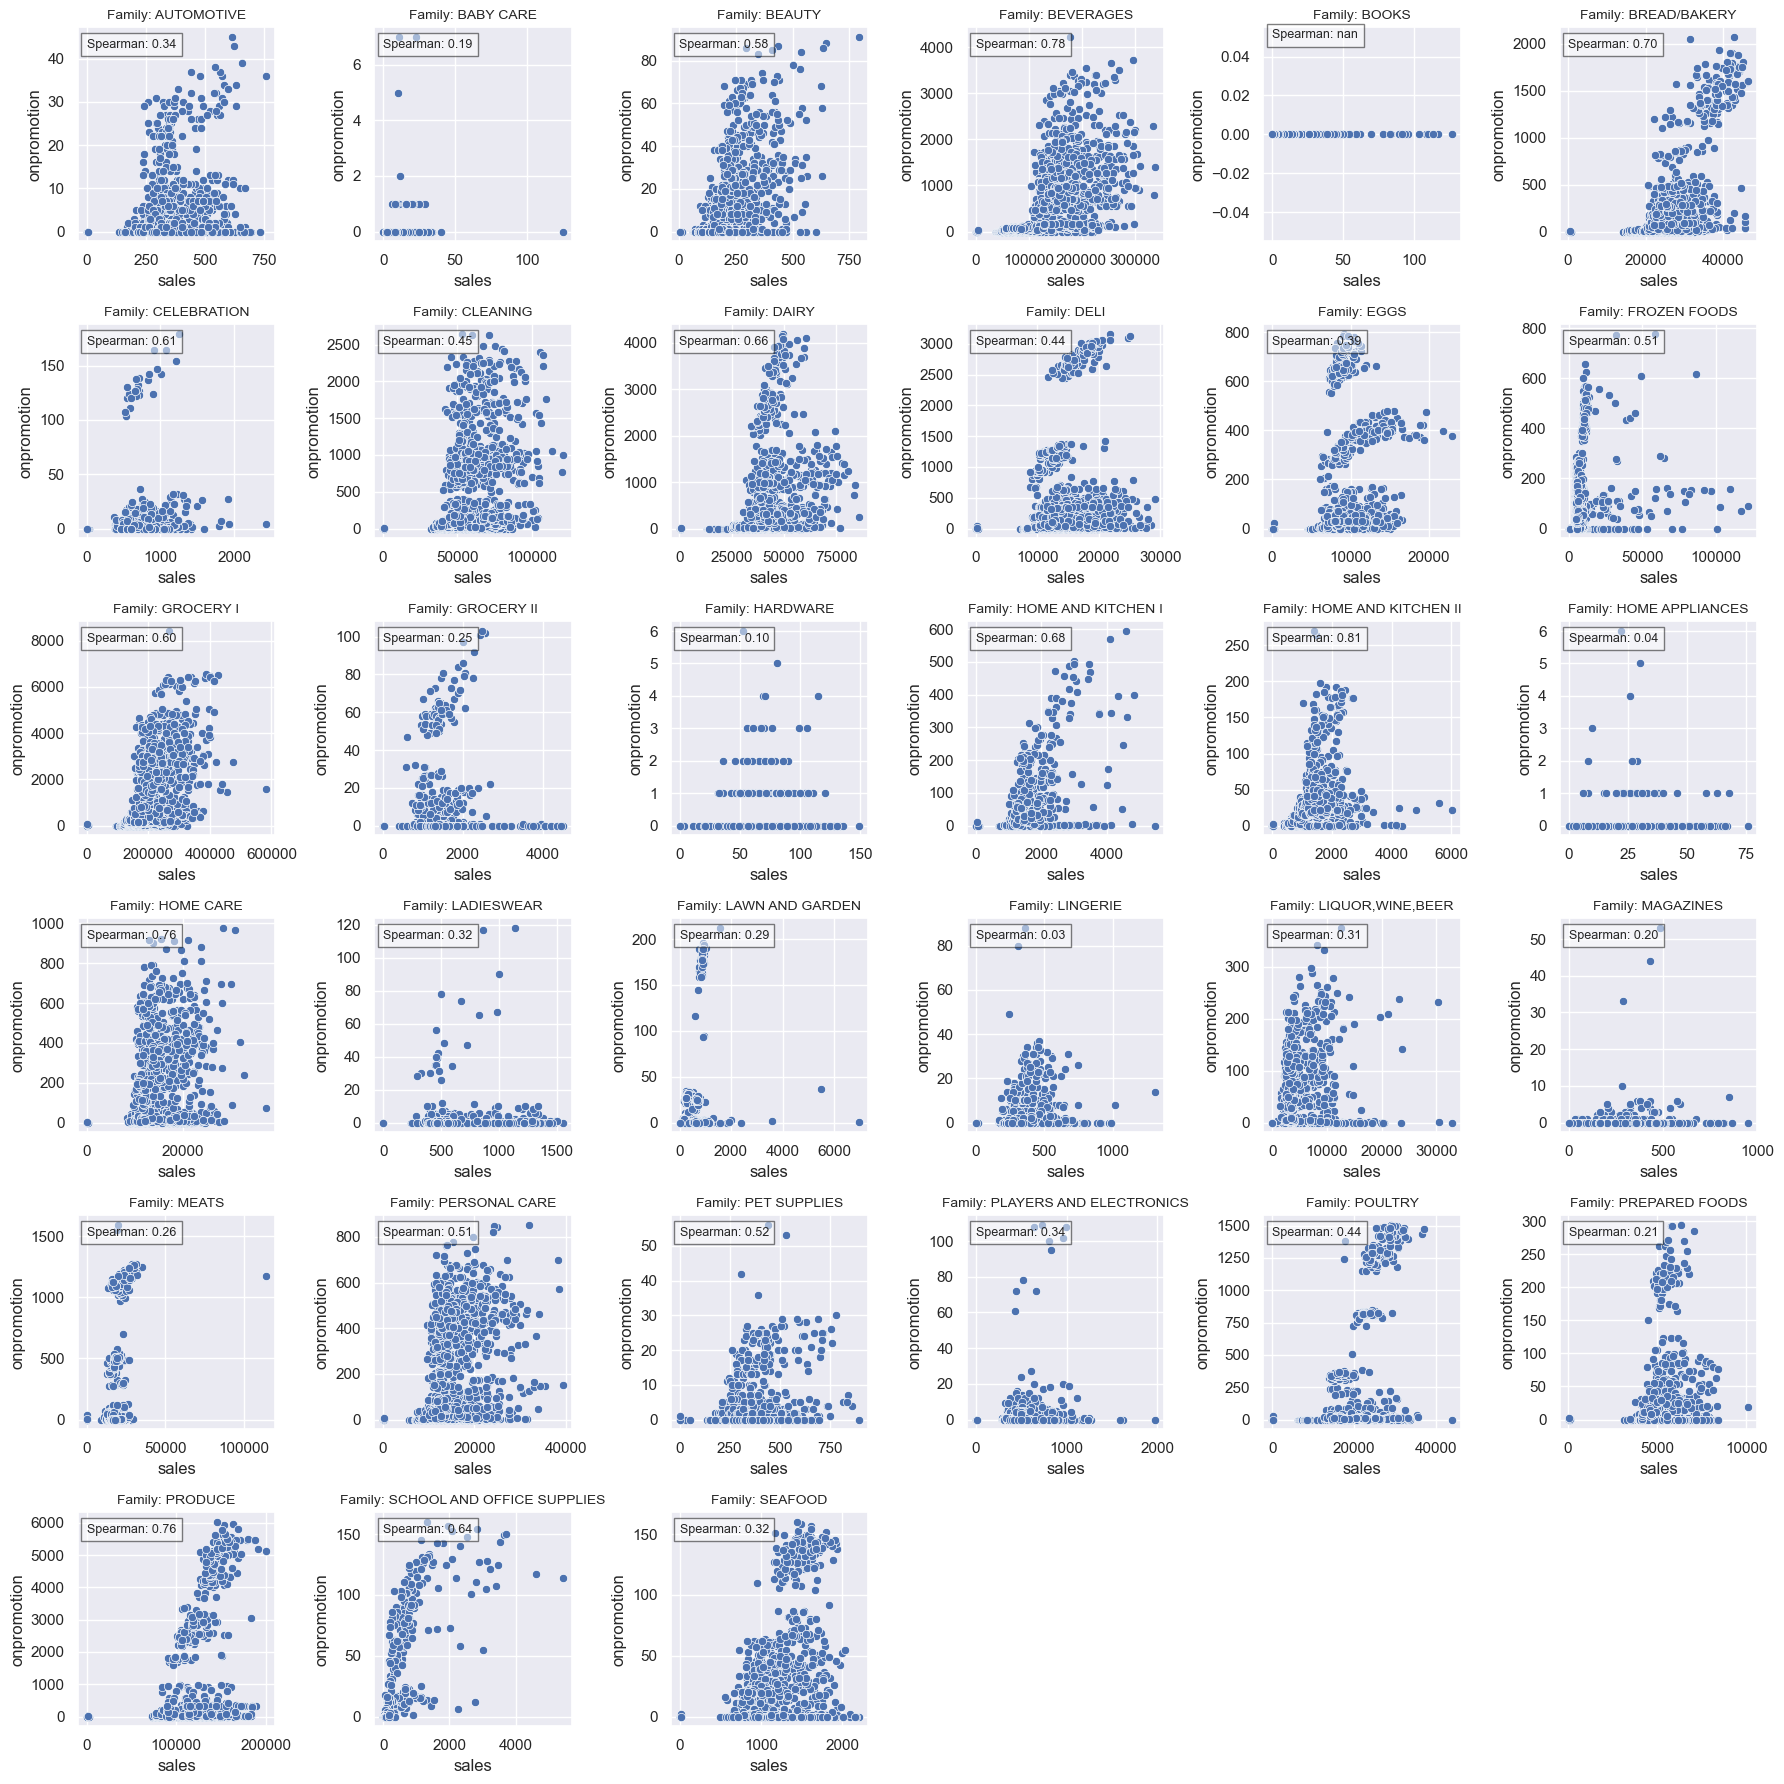

In [57]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Scatter plot
    sns.scatterplot(ax=axes[j], data=temp_filter, x='sales', y='onpromotion')

    # Spearman correlation
    spearman_correlation = temp_filter['sales'].corr(temp_filter['onpromotion'], method='spearman')
    textstr = f"Spearman: {spearman_correlation:.2f}"

    # Add correlation text
    x_pos = temp_filter['sales'].min() * 0.7
    y_min, y_max = axes[j].get_ylim()
    y_pos = y_max * 0.9

    axes[j].text(
        x=x_pos,
        y=y_pos,
        s=textstr,
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
    )
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

In [86]:
first_sale_date

2       2013-01-01
3       2013-01-01
5       2013-01-01
7       2013-01-01
8       2013-01-01
           ...    
55567   2013-01-01
55568   2013-01-01
55569   2013-03-16
55570   2014-01-02
55571   2013-01-02
Name: date, Length: 47503, dtype: datetime64[ns]

In [93]:
#### Creating a table for product performance comparison
### The dataset has a standard of showing every family product per day, even if the product was not sold at the time
### So we get the first sale date and drop everything before that so we have the accurate sales per day
mask = prd_sales_df['sales'] != 0
first_sale_date = prd_sales_df.where(mask).groupby('family')['date'].transform('min')
filtered_prd_sl_df = prd_sales_df[prd_sales_df['date'] >= first_sale_date]
filtered_prd_sl_df.groupby('family', as_index= False).agg({'sales':['mean','sum'],'onpromotion':['mean','sum'], 'date':['min','count']})

family          sales                onpromotion  \
                                         mean           sum         mean   
0                   AUTOMOTIVE     329.662507  5.548220e+05     2.841949   
1                    BABY CARE      11.280584  1.005100e+04     0.059484   
2                       BEAUTY     200.649050  3.378930e+05     8.006532   
3                    BEVERAGES  128832.830166  2.169545e+08   538.573634   
4                        BOOKS      22.432056  6.438000e+03     0.000000   
5                 BREAD/BAKERY   25020.157706  4.213395e+07   196.727435   
6                  CELEBRATION     746.984298  7.611770e+05     6.597645   
7                     CLEANING   57910.504157  9.752129e+07   392.611045   
8                        DAIRY   38294.364014  6.448771e+07   432.723872   
9                         DELI   14317.293628  2.411032e+07   346.387173   
10                        EGGS    9256.707838  1.558830e+07   115.749406   
11                FROZEN FOODS    8357.415511  1.407389e+07    74.604513   
12                   GROCERY I  203956.493400  3.434627e+08  1137.055226   
13                  GROCERY II    1165.538599  1.962767e+06     4.362827   
14                    HARDWARE      61.552647  1.034700e+05     0.096966   
15          HOME AND KITCHEN I    1591.017949  1.861491e+06    40.103419   
16         HOME AND KITCHEN II    1299.717949  1.520670e+06    28.046154   
17             HOME APPLIANCES      25.136556  4.160100e+04     0.035045   
18                   HOME CARE   15303.480420  1.602274e+07   188.376313   
19                  LADIESWEAR     640.904528  6.511590e+05     1.653543   
20             LAWN AND GARDEN     325.915677  5.488420e+05     6.655582   
21                    LINGERIE     387.834917  6.531140e+05     1.671615   
22            LIQUOR,WINE,BEER    5143.851262  7.746640e+06    31.009296   
23                   MAGAZINES     246.628704  2.663590e+05     0.275000   
24                       MEATS   18459.898102  3.108647e+07   180.539192   
25               PERSONAL CARE   14603.355701  2.459205e+07   146.631829   
26                PET SUPPLIES     347.547758  3.565840e+05     3.167641   
27     PLAYERS AND ELECTRONICS     552.117763  5.626080e+05     1.839058   
28                     POULTRY   18928.743748  3.187600e+07   134.454276   
29              PREPARED FOODS    5225.590925  8.799895e+06    22.282660   
30                     PRODUCE   76214.089861  1.227047e+08   694.360870   
31  SCHOOL AND OFFICE SUPPLIES     265.074803  2.693160e+05    14.335630   
32                     SEAFOOD    1197.523400  2.015432e+06    23.203803   

                  date        
        sum        min count  
0      4783 2013-01-02  1683  
1        53 2014-03-01   891  
2     13483 2013-01-01  1684  
3    906958 2013-01-01  1684  
4         0 2016-10-08   287  
5    331289 2013-01-01  1684  
6      6723 2014-01-01  1019  
7    661157 2013-01-01  1684  
8    728707 2013-01-01  1684  
9    583316 2013-01-01  1684  
10   194922 2013-01-01  1684  
11   125634 2013-01-01  1684  
12  1914801 2013-01-01  1684  
13     7347 2013-01-01  1684  
14      163 2013-01-02  1681  
15    46921 2014-01-01  1170  
16    32814 2014-01-01  1170  
17       58 2013-01-02  1655  
18   197230 2014-01-01  1047  
19     1680 2014-01-02  1016  
20    11208 2013-01-01  1684  
21     2815 2013-01-01  1684  
22    46700 2013-01-01  1506  
23      297 2014-01-01  1080  
24   304028 2013-01-01  1684  
25   246928 2013-01-01  1684  
26     3250 2014-01-01  1026  
27     1874 2014-01-01  1019  
28   226421 2013-01-01  1684  
29    37524 2013-01-01  1684  
30  1117921 2013-03-16  1610  
31    14565 2014-01-02  1016  
32    39052 2013-01-02  1683

##### Analysis
We can see that the products have multiple starting points and have different patterns. Some sales also don't have a high correlation with promotions

#### Creating the final file

In [23]:
transactions_df.head(1)

,date,store_nbr,transactions
0,2013-01-01,25,770


In [24]:
stores_df.head(1)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13


In [25]:
train_df.tail(1)

,id,date,store_nbr,family,sales,onpromotion
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0


In [26]:
test_df.head(1)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0


In [27]:
store_prod = train_df[['store_nbr','family']].drop_duplicates().copy()
store_prod = store_prod.merge(stores_df, how = 'left', on = 'store_nbr')

In [28]:
store_prod

,store_nbr,family,city,state,type,cluster
0,1,AUTOMOTIVE,Quito,Pichincha,D,13
1,1,BABY CARE,Quito,Pichincha,D,13
2,1,BEAUTY,Quito,Pichincha,D,13
3,1,BEVERAGES,Quito,Pichincha,D,13
4,1,BOOKS,Quito,Pichincha,D,13
...,...,...,...,...,...,...
1777,9,POULTRY,Quito,Pichincha,B,6
1778,9,PREPARED FOODS,Quito,Pichincha,B,6
1779,9,PRODUCE,Quito,Pichincha,B,6
1780,9,SCHOOL AND OFFICE SUPPLIES,Quito,Pichincha,B,6
